In [1]:
from preamble import *

2025-02-10 22:12:22,478 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


  0%|          | 0/2 [00:00<?, ?it/s]

# Define the log probability

In [61]:
def lnprob(parameters, plot=False, plot_label=None,**kwargs):
    """
    Log-probability function for MCMC.

    Parameters:
    - parameters: np.ndarray, current parameter values.
    - kwargs: dict, additional arguments required for model computation.

    Returns:
    - ln_like: float, log-likelihood of the current parameter set.
    """
    ln_like = 0.0

    # Map parameters to names for easier reference
    params = {name: value for name, value in zip(params_config.keys(), parameters)}

    'Check if all priors are satisfied'
    if all(bounds[0] <= params[key] <= bounds[1] for key, bounds in priors.items()):

        'Set binning preferences and download model spectra'
        kwargs = dict(
        bin_specification = 'edges',
        bins=bin_edges,
        min=bin_edges.min(),
        max=bin_edges.max(), log=False)
        Cool, Phot = [
            bin_spectrum(
                get_spectrum(T_eff=Temp, log_g=log_g, Z=0.12, cache=True), **kwargs
            )
            for Temp in [params.get('T_spot', default_params['T_spot']), params.get('T_phot', default_params['T_phot'])] ]

        'Update Planet Parameters'
        planet_parameters['a'] = params.get('a_rstar', default_params['a_rstar'])
        planet_parameters['ecc'] = params.get('ecc', default_params['ecc'])
        planet_parameters['inclination'] = np.radians(params.get('planet_i', default_params['planet_i']))
        planet_parameters['u1'] = params.get('u1', default_params['u1'])
        planet_parameters['u2'] = params.get('u2', default_params['u2'])
        planet_parameters['rp'] = ((params.get('R_0', default_params['R_0']) * u.R_earth) / Rs).decompose()

        if visit == 'F21':
            planet_parameters['t0'] = 0
            lc_index=1
        if visit == 'S22':
            planet_parameters['t0'] = params.get('T_0', default_params['T_0'])
            lc_index=0
        
        # Update stellar parameters
        active_star.T_eff = Phot.meta['PHXTEFF']
        active_star.phot = Phot.flux.value
        active_star.wavelength = Phot.wavelength.to_value(u.m)
        active_star.temperature = jnp.array([Cool.meta['PHXTEFF']] * n_spots)
        active_star.spectrum = jnp.array([Cool.flux.value] * n_spots)
        active_star.lon = jnp.array([params.get(f"spot{i}_lon", default_params[f"spot{i}_lon"]) for i in range(1, n_spots + 1)])
        active_star.lat = jnp.array([params.get(f"spot{i}_lat", default_params[f"spot{i}_lat"]) for i in range(1, n_spots + 1)])
        active_star.rad = jnp.array([params.get(f"spot{i}_rad", default_params[f"spot{i}_rad"]) for i in range(1, n_spots + 1)])

        if plot:
            'Plot the stellar surface'
            active_star.plot_star(
                t0=0,
                rp=(params.get('R_0', default_params['R_0']) * u.R_earth / Rs).decompose(),  # Exoplanet radius in units of stellar radii
                a=params.get('a_rstar', default_params['a_rstar']),  # Planetary semi-major axis in units of stellar radii
                inclination=np.radians(params.get('planet_i', default_params['planet_i'])),  # Planetary orbital inclination [radians]
                ecc=params.get('ecc', default_params['ecc'])  # Planetary eccentricity
            )
            plt.title(f'AU Mic at T0')
            plt.savefig(f'{plot_label}_activestarplot.png', dpi=300)
            plt.show()
            plt.clf()
        
            'Set up the data + model plots'
            fig, axes = plt.subplots(3, 1, figsize=(6, 6))
            axes[0].set_title(f"{visit}")
            axes[0].set_xlabel("Time from midtransit")
            axes[0].set_ylabel("Relative Flux")
            axes[1].set_title("Systematic-corrected")
            axes[1].set_xlabel("Time from midtransit")
            axes[2].set_title("Residuals")
            axes[2].set_xlabel("Time from midtransit")
            axes[2].set_ylabel(r"$\sigma$")
            
            total_chisq = 0
            for data_flux, relative_err, img_date, time_from_T0, direction, ramp_phase in zip(data_fluxes, relative_errs, img_dates, times_from_T0, ['Forward', 'Backward'], ramp_phases):
                active_star.times = time_from_T0
                lc, contam, X, Y, spectrum_at_transit = active_star.transit_model(**planet_parameters)
            
                ramp = ramp_model(params.get('r1', default_params['r1']),
                                  params.get('r2', default_params['r2']),
                                  params.get('r3', default_params['r3']),
                                  ramp_phase)
                # breathing = breathing_effect(b1=params.get('b1', default_params['b1']),
                #                              b2=params.get('b2', default_params['b2']),
                #                              b3=params.get('b3', default_params['b3']),
                #                              b4=params.get('b4', default_params['b4']),
                #                              phase=ramp_phase)
                # systematics = ramp * breathing
                systematics = ramp
            
                fleck_lc = lc.T[lc_index]
                fleck_lc /= np.nanmean(fleck_lc)
                model = systematics * fleck_lc
                normalized_model = model / np.nanmean(model)
                normalized_flux = data_flux / np.nanmean(data_flux)
                chisq = np.nansum(((normalized_flux - normalized_model) ** 2) / (relative_err ** 2))
                total_chisq+=chisq
                
                # First plot (data + model)
                axes[0].errorbar(
                    time_from_T0,
                    normalized_flux,
                    yerr=relative_err,label=f'{direction}',fmt='o',ms=2,alpha=0.9)
                # Second plot (data & model)/systematics
                axes[1].errorbar(
                    time_from_T0,
                    (normalized_flux/systematics),
                    yerr=relative_err,label=f'{direction}',fmt='o',ms=2,alpha=0.9)
                # third plot (data & model)/systematics
                axes[2].scatter(
                    time_from_T0,
                    (normalized_flux-normalized_model)/relative_err,s=1.5,alpha=0.8)
                
                if direction =='Forward':
                    axes[0].plot(
                        time_from_T0,
                        normalized_model,alpha=0.8,
                        color='k',zorder=100,label='Spotted Transit + Systematics')
                    axes[1].plot(
                        time_from_T0,
                        fleck_lc,alpha=0.8,
                        color='k',zorder=100,label='Spotted Transit')
                    
            axes[0].legend(loc='upper right',fontsize=10)
            axes[1].legend(loc='upper right',fontsize=10)
            plt.savefig(f'../figs/{visit}_lightcurvemodels.png')
            plt.show()

            reduced_chisq = total_chisq/( 2*np.sum(~np.isnan(time_from_T0)) - ndim)
            print(f'This Models Reduced Chisq = {reduced_chisq} for {ndim} parameters and {2*np.sum(~np.isnan(time_from_T0))} data points')

            fig, axes = plt.subplots(4, 1, figsize=(7, 6),sharex=True)
            axes[0].set_title(f"{visit}")
            axes[0].set_ylabel("Relative Flux")
            axes[1].set_title("Systematic-corrected")
            axes[1].set_ylabel("Relative Flux")
            axes[2].set_title("Rotation-corrected")
            axes[2].set_ylabel("Relative Flux") 
            axes[2].set_title("Residuals")
            axes[3].set_xlabel("Time from midtransit")
            axes[3].set_ylabel(r"$\sigma$")
            axes[0].set_ylim(0.9955,1.0045)
            axes[1].set_ylim(0.9955,1.0045)
            # axes[2].set_ylim(0.9955,1.002)
            
            for data_flux, relative_err, img_date, time_from_T0, direction, ramp_phase in zip(data_fluxes, relative_errs, img_dates, times_from_T0, ['Forward', 'Backward'], ramp_phases):
                active_star.times = time_from_T0
                lc, contam, X, Y, spectrum_at_transit = active_star.transit_model(**planet_parameters)
            
                ramp = ramp_model(params.get('r1', default_params['r1']),
                                  params.get('r2', default_params['r2']),
                                  params.get('r3', default_params['r3']),
                                  ramp_phase)
                # breathing = breathing_effect(b1=params.get('b1', default_params['b1']),
                #                              b2=params.get('b2', default_params['b2']),
                #                              b3=params.get('b3', default_params['b3']),
                #                              b4=params.get('b4', default_params['b4']),
                #                              phase=ramp_phase)
                systematics = ramp
            
                fleck_lc = lc.T[lc_index]
                fleck_lc /= np.nanmean(fleck_lc)
                model = systematics * fleck_lc
                normalized_model = model / np.nanmean(model)
                normalized_flux = data_flux / np.nanmean(data_flux)

                rot = active_star.rotation_spectrum()
                rotation = rot.T[lc_index]
                rotation/=np.nanmean(rotation)
                
                # First plot (data + model)
                axes[0].errorbar(
                    time_from_T0,
                    normalized_flux,
                    yerr=relative_err,label=f'{direction}',fmt='o',ms=1,alpha=0.9)
                # Second plot (data & model)/systematics
                axes[1].errorbar(
                    time_from_T0,
                    (normalized_flux/systematics)/np.nanmean(normalized_flux/systematics),
                    yerr=relative_err,label=f'{direction}',fmt='o',ms=1,alpha=0.9)
                axes[2].errorbar(
                    time_from_T0,
                    normalized_flux/(systematics*rotation)/np.nanmean(normalized_flux/(systematics*rotation)),
                    yerr=relative_err,label=f'{direction}',fmt='o',ms=1,alpha=0.9)
                # third plot (data & model)/systematics
                axes[3].scatter(
                    time_from_T0,
                    (normalized_flux-normalized_model)/relative_err, s=1,alpha=0.8)
                
                if direction =='Forward':
                    axes[0].plot(
                        time_from_T0,
                        normalized_model,alpha=0.8,label='fleck x ramp',
                        color='k',zorder=100)
                    axes[1].plot(
                        time_from_T0,
                        fleck_lc,alpha=0.8,
                        color='k',zorder=100,label='fleck (transit and rotation)')
                    axes[2].plot(
                        time_from_T0,
                        (fleck_lc/rotation_curve)/np.nanmean(fleck_lc/rotation_curve),alpha=0.8,
                        color='k',zorder=100,label='transit/rotation')
                    
            plt.xlim(-0.1,0.1)
            axes[0].legend(loc='upper right',fontsize=10)
            axes[1].legend(loc='upper right',fontsize=10)
            plt.savefig(f'../figs/{visit}_lightcurvemodels_zoomedin.png',dpi=300)
            plt.show()
            
        for data_flux, relative_err, img_date, time_from_T0, direction, ramp_phase in zip(data_fluxes, relative_errs, img_dates, times_from_T0, ['Forward', 'Backward'], ramp_phases):
            active_star.times = time_from_T0
            
            lc, contam, X, Y, spectrum_at_transit = active_star.transit_model(**planet_parameters)
            
            ramp = ramp_model(params.get('r1', default_params['r1']),
                              params.get('r2', default_params['r2']),
                              params.get('r3', default_params['r3']),
                              ramp_phase)
            # breathing = breathing_effect(b1=params.get('b1', default_params['b1']),
            #                              b2=params.get('b2', default_params['b2']),
            #                              b3=params.get('b3', default_params['b3']),
            #                              b4=params.get('b4', default_params['b4']),
            #                              phase=ramp_phase)
            
            systematics = ramp
        
            fleck_lc = lc.T[lc_index]
        
            fleck_lc /= np.nanmean(fleck_lc)
            model = systematics * fleck_lc
            normalized_model = model / np.nanmean(model)
            normalized_flux = data_flux / np.nanmean(data_flux)
            chisq = np.nansum(((normalized_flux - normalized_model) ** 2) / (relative_err ** 2))
            err_weight = np.nansum(1.0 / np.sqrt(2.0 * np.pi * (relative_err)))
        
            ln_like += (err_weight - 0.5 * chisq)      

        return ln_like

    else:
        return -np.inf

## Set up MCMC

In [48]:
F21_default_params={
    # Ramp Model Parameters
    "r1": 18.1,
    "r2": -6.84,
    "r3": 6.7e-5,
    # Transit Parameters
    "T_0":0.0,
    "u1": 0.208,
    "u2": 0.37,
    "R_0": 3.7,
    "a_rstar": 18.2,
    "ecc": 0.06,
    'planet_i': 89.5, # Range from 85 to 90 deg, or 1.47-1.57radians
    # Stellar Parameters
    "T_spot": 3100,
    "T_phot": 4000,
    "spot1_lon": -1.291,
    "spot1_lat": 0.59,
    "spot1_rad": 0.644,
    "spot2_lon": 0.06,
    "spot2_lat": 1.269,
    "spot2_rad": 0.457,
    "spot3_lon": 1.237,
    "spot3_lat": 2.52,
    "spot3_rad": 0.515,
    "spot4_lon": 0.844,
    "spot4_lat": 1.781,
    "spot4_rad": 0.0,
}

S22_default_params={
    # Ramp Model Parameters
    "r1": 17.32,
    "r2": -6.64,
    "r3": 0.00149,
    # Transit Parameters
    "T_0":0.0,
    "u1": 0.236,
    "u2": 0.395,
    "R_0": 3.7,
    "a_rstar": 18.2,
    "ecc": 0.062,
    'planet_i': 89.5, # Range from 85 to 90 deg, or 1.47-1.57radians
    # Stellar Parameters
    "T_spot": 3100,
    "T_phot": 4000,
    "spot1_lon": -1.293,
    "spot1_lat": 0.747,
    "spot1_rad": 0.635,
    "spot2_lon": 0.14,
    "spot2_lat": 1.236,
    "spot2_rad": 0.49,
    "spot3_lon": 1.236,
    "spot3_lat": 2.58,
    "spot3_rad": 0.57,
    "spot4_lon": 0.848,
    "spot4_lat": 1.78,
    "spot4_rad": 0.059,
}

F21_params_config={
    # Ramp Model Parameters
    "r1": (17.0,18.5),
    "r2": (-7.0,-6.5),
    "r3": (0.00001,0.0001),
    # Transit Parameters
    "u1": (0.2,0.23),
    "u2": (0.36, 0.39),
    "R_0": (3.55,3.8),
    "a_rstar": (18.0,18.5),
    "ecc": (0.02,0.09),
    # 'planet_i': 89.5, # Range from 85 to 90 deg, or 1.47-1.57radians
    # Stellar Parameters
    "T_spot": (3000,3200),
    "T_phot": (3900,4100),
    #spot 1 is the spot coming into view, driving the overall slope
    "spot1_lon": (-1.297,-1.277),
    "spot1_lat": (0.6,0.75),
    "spot1_rad": (0.6,0.8),
    # Spot 2 is a central spot, both transits appear to graze this spot
    "spot2_lon": (0.05,0.1),
    "spot2_lat": (1.2,1.3),
    "spot2_rad": (0.4,0.55),
    # Spot 3 is going out of view, and affects the higher order shape of the light curve
    "spot3_lon": (1.15,1.35),
    "spot3_lat": (2.2,2.8),
    "spot3_rad": (0.4,0.8),
    # Spot 4 is on the transit chord, seen in the S22 visit
    "spot4_lon": (0.8,0.86),
    "spot4_lat": (1.775,1.795),
    "spot4_rad": (0.04,0.07)
}

S22_params_config={
    # Ramp Model Parameters
    # "r1": (17.1,18.3),
    # "r2": (-7.5,-6.5),
    "r3": (0.0001,0.0002),
    # Transit Parameters
    "u1": (0.25,0.29),
    "u2": (0.36,0.395),
    "R_0": (3.55,3.75),
    "a_rstar": (18,18.5),
    "ecc": (0.03,0.07),
    # 'planet_i': 89.5, # Range from 85 to 90 deg, or 1.47-1.57radians
    # Stellar Parameters
    "T_spot": (3050,3150),
    "T_phot": (3950,4150),
    #spot 1 is the spot coming into view, driving the overall slope
    "spot1_lon": (-1.295,-1.275),
    "spot1_lat": (0.65,0.73),
    "spot1_rad": (0.62,0.67),
    # Spot 2 is a central spot, both transits appear to graze this spot
    "spot2_lon": (0.12,0.14),
    "spot2_lat": (1.275,1.295),
    "spot2_rad": (0.4,0.5),
    # Spot 3 is going out of view, and affects the higher order shape of the light curve
    "spot3_lon": (1.19,1.25),
    "spot3_lat": (2.5,2.6),
    "spot3_rad": (0.48,0.58),
    # Spot 4 is on the transit chord, seen in the S22 visit
    "spot4_lon": (0.82,0.85),
    "spot4_lat": (1.77,1.785),
    "spot4_rad": (0.045,0.06)
}

priors={
    # Ramp Model Parameters
    # "r1": (17.0,19.0),
    # "r2": (-7.5,-6.4),
    "r3": (0,0.0005),
    # Transit Parameters
    "u1": (0.2,0.3),
    "u2": (0.25,0.4),
    "R_0": (3.4,3.9),
    "a_rstar": (17.5,19.5),
    "ecc": (0.01,0.15),
    # 'planet_i': 89.5, # Range from 85 to 90 deg, or 1.47-1.57radians
    # Stellar Parameters
    "T_spot": (2900,3200),
    "T_phot": (3900,4200),
    #spot 1 is the spot coming into view, driving the overall slope
    "spot1_lon": (-1.3,-1.27),
    "spot1_lat": (0.55,0.75),
    "spot1_rad": (0.4,0.85),
    # Spot 2 is a central spot, both transits appear to graze this spot
    "spot2_lon": (0.01,0.15),
    "spot2_lat": (1.15,1.35),
    "spot2_rad": (0.35,0.55),
    # Spot 3 is going out of view, and affects the higher order shape of the light curve
    "spot3_lon": (1.1,1.5),
    "spot3_lat": (2.2,2.8),
    "spot3_rad": (0.3,0.8),
    # Spot 4 is on the transit chord, seen in the S22 visit
    "spot4_lon": (0.8,0.86),
    "spot4_lat": (1.76,1.79),
    "spot4_rad": (0.035,0.07)
}

In [50]:
default_params = S22_default_params
params_config = S22_params_config

Rs = 0.8 * u.R_sun
log_g = calculate_logg(Rs.value)
T_eq = 600
M_p = 10.2 * u.R_earth 
n_spots = 4
orbits_to_exclude = np.array([0])
orbits_to_include = np.array([1,2,3,4,5,6,7])
bin_edges = np.array([0.81, 1.13, 1.64])*u.micron

err_inflation = 3.0

nwalkers = 200
ndim = len(priors)
nsteps = 1000
burnin = int(0.5*nsteps)

'Set binning preferences and download initial spectra'
kwargs = dict(
    bin_specification = 'edges',
    bins=bin_edges,
    min=bin_edges.min(),
    max=bin_edges.max(),
    log=False)
Cool, Phot = [
    bin_spectrum(
        get_spectrum(T_eff=Temp, log_g=log_g, Z=0.12, cache=True), **kwargs)
    for Temp in [default_params['T_spot'], default_params['T_phot']] ]

'Initialize planet parameters and the active_star'
planet_parameters = dict(
    inclination = np.radians(default_params['planet_i']),
    a = default_params['a_rstar'],
    rp = (default_params['R_0']*u.R_earth/Rs).decompose(),
    period = 8.463,
    t0 = default_params['T_0'],
    ecc = default_params['ecc'],
    u1 = default_params['u1'],
    u2 = default_params['u2'] )
active_star = ActiveStar(
    # times=np.linspace(-0.3,0.3,200),
    inclination=np.pi/2,  # stellar inc [rad]
    T_eff=Phot.meta['PHXTEFF'],
    wavelength=Phot.wavelength.to_value(u.m), #use data wavelength array
    phot=Phot.flux.value, #This is the model spectrum for the photosphere temp
    P_rot=4.863 )
for i in range(1, n_spots + 1):
    # Generate random values within the parameter space for each spot
    lon = default_params[f"spot{i}_lon"]
    lat = default_params[f"spot{i}_lat"]
    rad = default_params[f"spot{i}_rad"]

    spot = dict(
        lon=lon,  # Longitude [rad]
        lat=lat,  # Latitude [rad]
        rad=rad,  # Radius [R_star]
        spectrum=Cool.flux.value,  # Use provided spectrum
        temperature=Cool.meta['PHXTEFF'],  # Use provided temperature
    )
    # Add the spot to the active star
    active_star.add_spot(**spot)

# Run the MCMC

Running  S22

Mean Photon Error for S22 Forward = 42.67779951545215ppm
Mean Photon Error for S22 Reverse = 42.407839076576145ppm


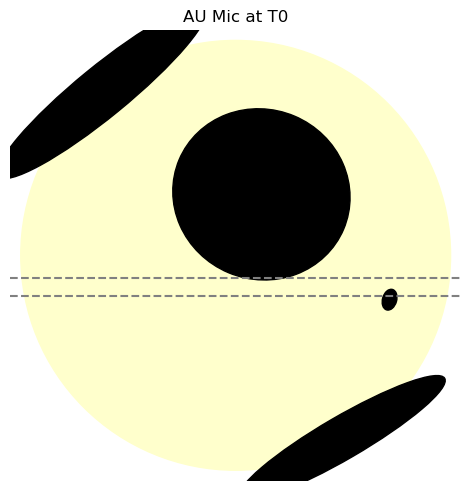

<Figure size 640x480 with 0 Axes>

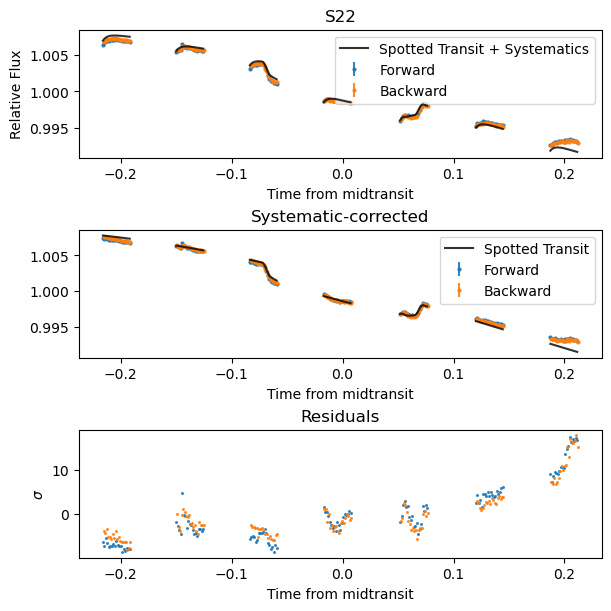

This Models Reduced Chisq = 40.35140370934959 for 20 parameters and 266 data points


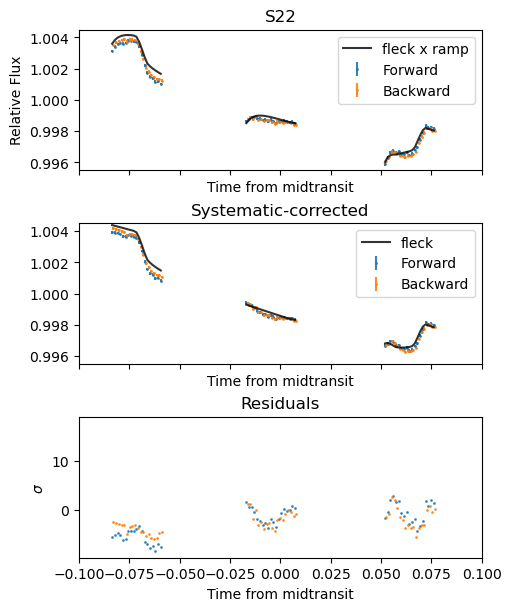

Running MCMC sampler...


100%|██████████| 800/800 [9:11:21<00:00, 41.35s/it]   


(Nsteps-burnin)*nwalkers/tau= 241
(Nsteps-burnin)*nwalkers/tau= 133
(Nsteps-burnin)*nwalkers/tau= 190
(Nsteps-burnin)*nwalkers/tau= 600
(Nsteps-burnin)*nwalkers/tau= 322
(Nsteps-burnin)*nwalkers/tau= 326
(Nsteps-burnin)*nwalkers/tau= 326
(Nsteps-burnin)*nwalkers/tau= 185
(Nsteps-burnin)*nwalkers/tau= 369
(Nsteps-burnin)*nwalkers/tau= 174
(Nsteps-burnin)*nwalkers/tau= 292
(Nsteps-burnin)*nwalkers/tau= 145
(Nsteps-burnin)*nwalkers/tau= 284
(Nsteps-burnin)*nwalkers/tau= 266
(Nsteps-burnin)*nwalkers/tau= 213
(Nsteps-burnin)*nwalkers/tau= 306
(Nsteps-burnin)*nwalkers/tau= 149
(Nsteps-burnin)*nwalkers/tau= 299
(Nsteps-burnin)*nwalkers/tau= 327
(Nsteps-burnin)*nwalkers/tau= 348
Best-fit parameter set: [ 1.14914279e-04  2.36082236e-01  3.95235946e-01  3.65004297e+00
  1.79830609e+01  6.24343275e-02  3.13777384e+03  4.02789761e+03
 -1.29326356e+00  7.46994068e-01  6.35100383e-01  1.40173855e-01
  1.23604037e+00  4.89846717e-01  1.23636826e+00  2.57967348e+00
  5.65840741e-01  8.48233679e-01  1.

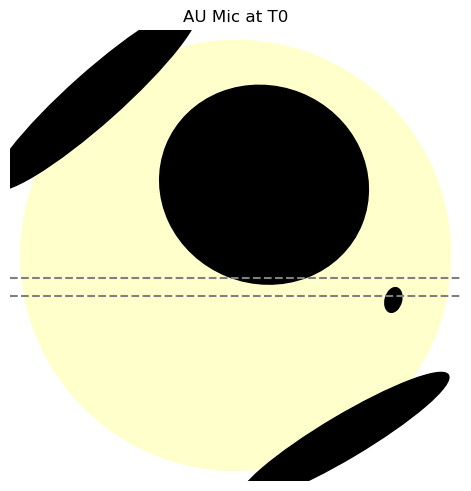

<Figure size 640x480 with 0 Axes>

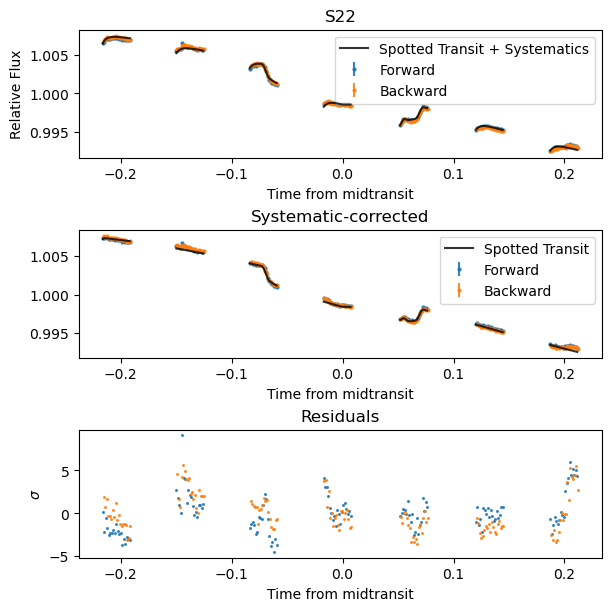

This Models Reduced Chisq = 5.110148608199949 for 20 parameters and 266 data points


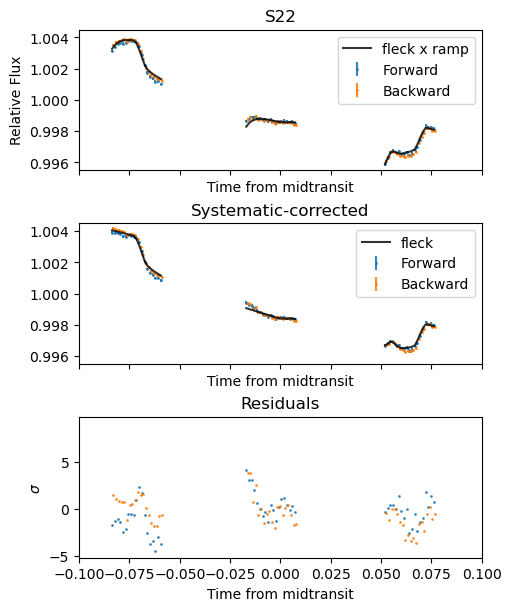

r3: 0.000138 +0.000035 -0.000035
--------------
u1: 0.226848 +0.031915 -0.017886
--------------
u2: 0.393225 +0.004235 -0.006414
--------------
R_0: 3.655587 +0.022641 -0.038323
--------------
a_rstar: 18.149648 +0.319207 -0.302587
--------------
ecc: 0.051651 +0.017867 -0.018349
--------------
T_spot: 3130.073393 +13.510202 -23.482752
--------------
T_phot: 4030.882781 +25.720090 -28.848819
--------------
spot1_lon: -1.284728 +0.007082 -0.006360
--------------
spot1_lat: 0.745796 +0.002925 -0.006061
--------------
spot1_rad: 0.648162 +0.023402 -0.022029
--------------
spot2_lon: 0.143868 +0.004924 -0.011869
--------------
spot2_lat: 1.245097 +0.021074 -0.016442
--------------
spot2_rad: 0.484109 +0.015164 -0.020630
--------------
spot3_lon: 1.201589 +0.025254 -0.020712
--------------
spot3_lat: 2.584906 +0.013717 -0.017074
--------------
spot3_rad: 0.592050 +0.025352 -0.034012
--------------
spot4_lon: 0.842889 +0.006893 -0.008447
--------------
spot4_lat: 1.778366 +0.005004 -0.004602

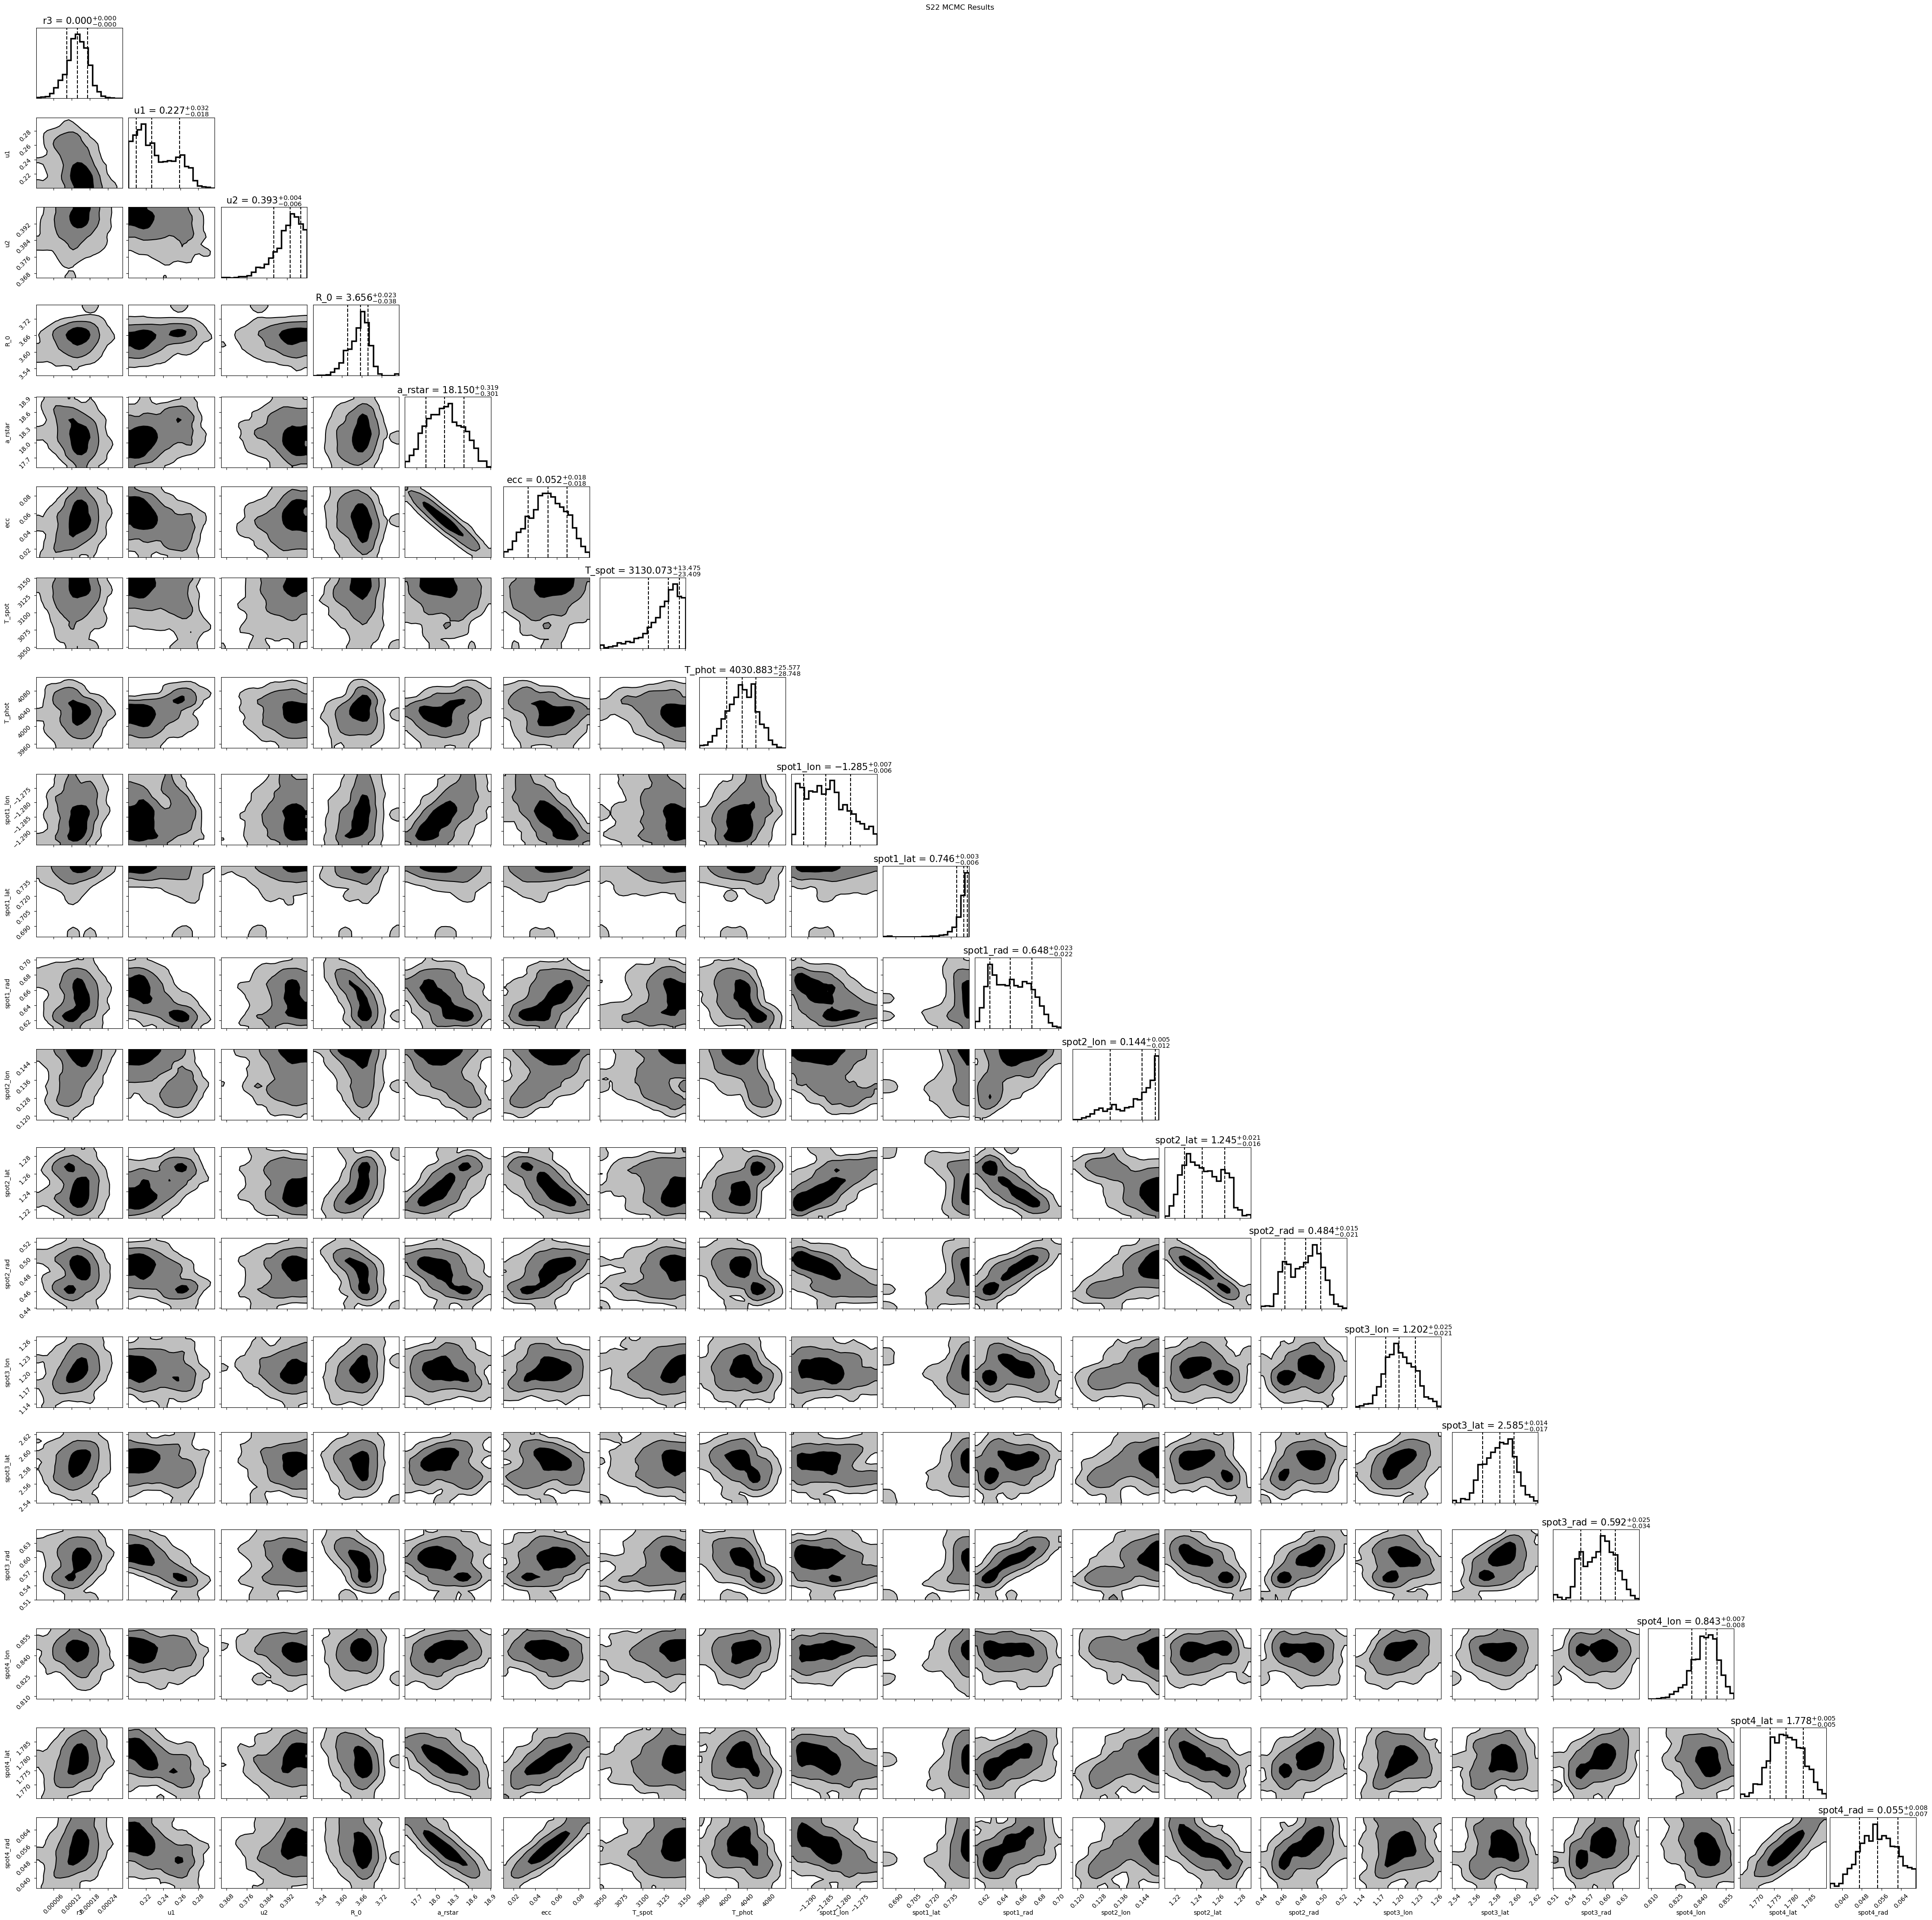

Running  F21

Mean Photon Error for F21 Forward = 41.58850331544239ppm
Mean Photon Error for F21 Reverse = 41.593266985873534ppm


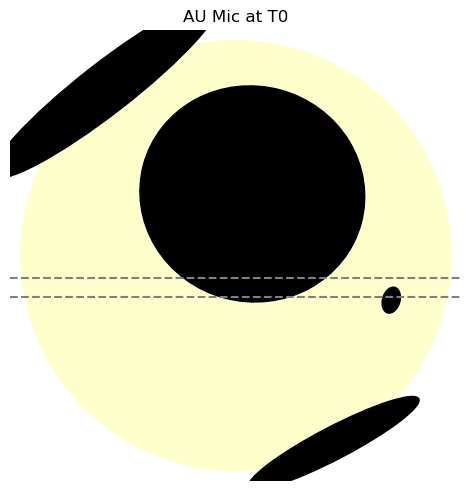

<Figure size 640x480 with 0 Axes>

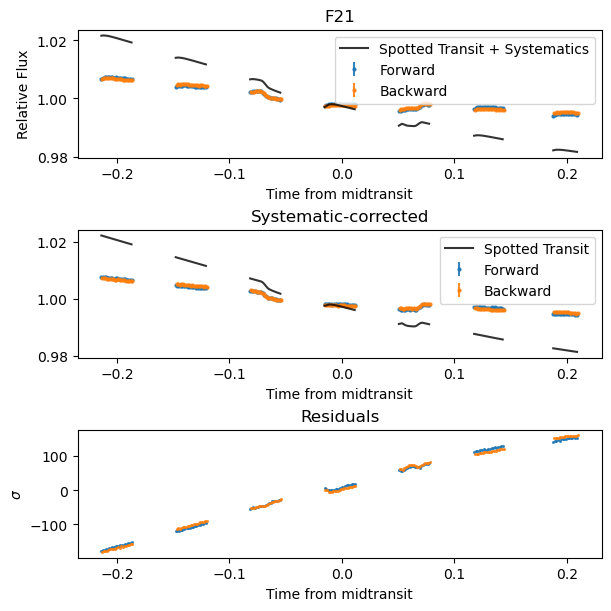

This Models Reduced Chisq = 12438.5535 for 20 parameters and 270 data points


Running MCMC sampler...


100%|██████████| 800/800 [9:47:36<00:00, 44.07s/it]   


(Nsteps-burnin)*nwalkers/tau= 163
(Nsteps-burnin)*nwalkers/tau= 125
(Nsteps-burnin)*nwalkers/tau= 208
(Nsteps-burnin)*nwalkers/tau= 243
(Nsteps-burnin)*nwalkers/tau= 233
(Nsteps-burnin)*nwalkers/tau= 221
(Nsteps-burnin)*nwalkers/tau= 223
(Nsteps-burnin)*nwalkers/tau= 385
(Nsteps-burnin)*nwalkers/tau= 277
(Nsteps-burnin)*nwalkers/tau= 327
(Nsteps-burnin)*nwalkers/tau= 260
(Nsteps-burnin)*nwalkers/tau= 214
(Nsteps-burnin)*nwalkers/tau= 196
(Nsteps-burnin)*nwalkers/tau= 223
(Nsteps-burnin)*nwalkers/tau= 253
(Nsteps-burnin)*nwalkers/tau= 276
(Nsteps-burnin)*nwalkers/tau= 230
(Nsteps-burnin)*nwalkers/tau= 343
(Nsteps-burnin)*nwalkers/tau= 218
(Nsteps-burnin)*nwalkers/tau= 174
Best-fit parameter set: [ 6.74848483e-05  2.07540971e-01  3.73723283e-01  3.74565941e+00
  1.80983082e+01  5.27167172e-02  3.00794836e+03  3.98114784e+03
 -1.29055161e+00  5.89662960e-01  6.44317488e-01  5.70495716e-02
  1.26884720e+00  4.57024177e-01  1.23724459e+00  2.52245212e+00
  5.14928357e-01  8.43677155e-01  1.

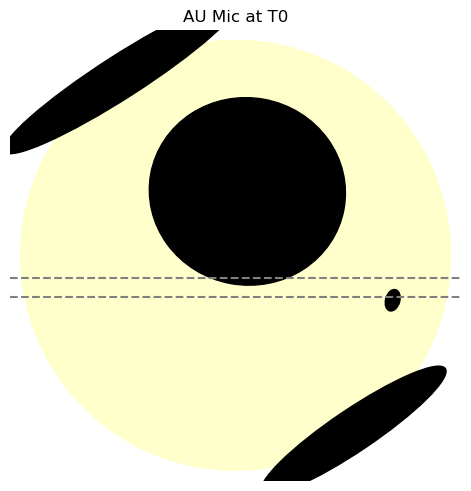

<Figure size 640x480 with 0 Axes>

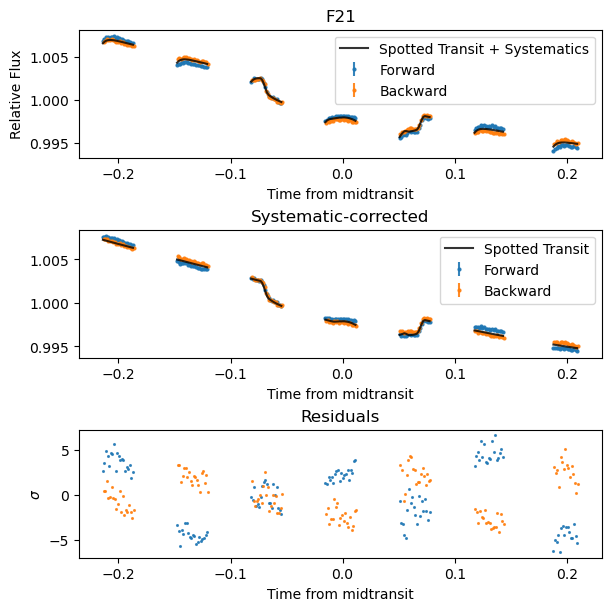

This Models Reduced Chisq = 9.7671796875 for 20 parameters and 270 data points


r3: 0.000081 +0.000036 -0.000046
--------------
u1: 0.211184 +0.008271 -0.006988
--------------
u2: 0.375228 +0.005210 -0.006149
--------------
R_0: 3.760605 +0.025089 -0.024229
--------------
a_rstar: 18.193828 +0.056983 -0.060667
--------------
ecc: 0.051327 +0.003724 -0.004515
--------------
T_spot: 3050.337179 +13.365495 -70.670794
--------------
T_phot: 3999.637482 +32.071548 -31.715094
--------------
spot1_lon: -1.291071 +0.004121 -0.003013
--------------
spot1_lat: 0.589562 +0.021641 -0.017939
--------------
spot1_rad: 0.636387 +0.011820 -0.013937
--------------
spot2_lon: 0.051969 +0.008961 -0.008456
--------------
spot2_lat: 1.259561 +0.010828 -0.006271
--------------
spot2_rad: 0.469215 +0.008525 -0.011897
--------------
spot3_lon: 1.266326 +0.024499 -0.031418
--------------
spot3_lat: 2.475452 +0.033324 -0.074213
--------------
spot3_rad: 0.484380 +0.022722 -0.030927
--------------
spot4_lon: 0.840307 +0.009329 -0.013141
--------------
spot4_lat: 1.779723 +0.004491 -0.005706

In [53]:
for visit in ['S22','F21']:

    if visit=='F21':
        default_params = F21_default_params
        params_config = F21_params_config
    if visit=='S22':
        default_params = S22_default_params
        params_config = S22_params_config
    
    print('Running ',visit)
    print('')
        
    'Extract exposure times and mid-transit times from the dictionary'
    predicted_T0 = visits[f'{visit}']['T0 (BJD_TDB)'].value
    exposureTime = visits[f'{visit}']['exp (s)'].value
    
    'Read in the trimmed rainbows from process_pacman_spectra.ipynb'
    data_fluxes = []
    relative_errs = []
    img_dates = []
    times_from_T0 = []
    for direction in ['Forward','Reverse']:
        rainbow = read_rainbow(f"../data/{visit}_{direction}_trimmed_pacman_spec.rainbow.npy")
        broadband_flux = np.nansum(rainbow.flux.value, axis=0)
        broadband_flux_err = np.sqrt(broadband_flux)
        relative_err = err_inflation*broadband_flux_err/broadband_flux
        print(f'Mean Photon Error for {visit} {direction} = {np.nanmean((broadband_flux_err/broadband_flux)*1e6)}ppm')
        data_fluxes.append(broadband_flux)
        relative_errs.append(relative_err)
        img_dates.append(rainbow.time.value)
        times_from_T0.append(rainbow.time.value - predicted_T0)
    
    'Label the orbits'
    orbit = np.zeros_like(img_dates[0])
    for j in range(len(img_dates[0])):
        if j >= 1:
            if (img_dates[0][j] - img_dates[0][j - 1]) > 0.01:
                orbit[j] = (orbit[j - 1] + 1)
            else:
                orbit[j] = orbit[j - 1]
    
    'Trim the first point from each orbit and the 3rd orbit from S22 (where there was a flare)'
    ref_time = []
    for o in np.unique(orbit):  # Skip the 0th orbit
        first_index = np.where(orbit == o)[0][0]
        ref_time.append(img_dates[0][first_index])
        for j in range(2):
            data_fluxes[j][first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
            relative_errs[j][first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
            img_dates[j][first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
            times_from_T0[j][first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
    
    'Trim any orbits defined in the initialization'
    for orbit_to_exclude in orbits_to_exclude:
        for j in range(2):
            data_fluxes[j][orbit == orbit_to_exclude] = np.nan
            relative_errs[j][orbit == orbit_to_exclude] = np.nan
            img_dates[j][orbit == orbit_to_exclude] = np.nan
            times_from_T0[j][orbit == orbit_to_exclude] = np.nan
    
    'Populate ramp_phase time arrays'
    ramp_phases=[0,0]
    for j in range(2):
        phase_list=[]
        for o in [0,1,2,3,4,5,6,7]:
            rphase = (img_dates[j][orbit==o] - ref_time[o]) / hst_per_in_days     # the data point at time "epoch" will be the zero-point; convert int phase by division through period
            phase_list.append(rphase)
        ramp_phases[j] = np.concatenate(phase_list)
    
    variable_names = list(params_config.keys())
    p0 = initialize_walkers(nwalkers, params_config)
    
    # Select a random set of parameters
    example_params = p0[np.random.randint(0, nwalkers - 1), :]
    
    # Call lnprob with the selected parameters and plot=True
    lnprob(example_params, plot=True)
    
    'Set up MCMC'
    label=f'{visit}_{nsteps}steps_whitelightcurve_{n_spots}spots_model'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,backend=backend)
    
    'Run the MCMC'
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    
    'Check for convergence (all should be > 100)'
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    'Return the Most likely set of parameters'
    flat_log_prob = sampler.get_log_prob(discard=burnin, flat=True)
    best_index = np.argmax(flat_log_prob)  # Index of the highest log-probability
    highest_prob_params = samples[:, best_index]
    print("Best-fit parameter set:", highest_prob_params)
    lnprob(highest_prob_params, plot=True,plot_label='Maximum Likelihood Parameters')
    
    'Extract and display best-fit parameters and uncertainties'
    median_params = []
    err_upper = []
    err_lower = []
    for i, param_samples in enumerate(samples):
        sig_1_results = np.percentile(param_samples, [15.9, 50.0, 84.1])
        median_params.append(sig_1_results[1])
        err_upper.append(sig_1_results[2] - sig_1_results[1])
        err_lower.append(sig_1_results[1] - sig_1_results[0])
    params_dict = {name: median_params[i] for i, name in enumerate(params_config.keys())}
    for i, label in enumerate(variable_names):
        print(f"{label}: {median_params[i]:.6f} +{err_upper[i]:.6f} -{err_lower[i]:.6f}")
        print("--------------")
    
    'Make corner plot'
    rng = 0.9995
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_corner.png')
    plt.show()